# ỨNG DỤNG CLUSTERING ĐỂ PHÁT HIỆN ẢNH TRÙNG

1. Yêu cầu chung: Dùng kỹ thuật clustering để tạo công cụ hỗ trợ phát hiện các ảnh trùng nhau

2. Yêu cầu cụ thể:
  - Input: Danh sách các ảnh được lưu trong tập tin, ví dụ CarDataset-Splits-1-Train.csv (xem mô tả https://colab.research.google.com/drive/1gf0GzvW0tHddKtuvMUNIvglUT-J6oW6S?usp=sharing)
  - Output: Danh sách các clusters và hiển thị các ảnh trong cluster

3. Hướng dẫn:
  - Bước 1:
    - Mỗi ảnh cần thực hiện bước rút trích đặc trưng (feature extraction), biểu diễn dưới dạng một vector đặc trưng d chiều (d-dimension).
    - Có nhiều công cụ hỗ trợ bước rút trích đặc trưng, trong bài tập này, chúng ta sẽ chọn một công cụ sao cho tốc độ xử lý nhanh nhưng kết quả tốt. Các mô hình MobileNet (https://keras.io/api/applications/mobilenet/) có thể được dùng vì đáp ứng các tiêu chí này.
  - Bước 2:
    - Chọn một thuật toán clustering - ví dụ K-Means (số lượng clusters K=5)
    - Ghi kết quả clustering ra tập tin - thay CategoryID bằng ClusterID
  - Bước 3:
    - Hiển thị kết quả clustering - kế thừa kết quả của bài tập Hiển thị dữ liệu https://colab.research.google.com/drive/1rHbKlJd7O9E49SsJlHnZNKcyTbwXT_Ls?usp=sharing
    - Từ kết quả hiển thị, nếu các ảnh nhìn trùng nhau, nhưng tên tập tin khác nhau thì có thể đưa vào danh sách hậu kiểm.

## Thông tin của tác giả, ngày cập nhật

* Trần Võ Lâm Trường - 22521586
* Ngô Nguyễn Nam Trung - 22521559

Ngày cập nhật: 11:13 05/01/2024

In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from math import ceil
from PIL import Image

In [3]:
# Đường dẫn gốc đến thư mục chứa ảnh
base_dir = r"/kaggle/input/car-cs114/dataset"

# Đọc file CSV
csv_file = r"/kaggle/input/car-cs114/car_split/car_split/CarDataset-Splits-5-Train.csv"
car_dataset = pd.read_csv(csv_file)

# Kết hợp đường dẫn ảnh
car_dataset["FullImagePath"] = car_dataset["ImageFullPath"].apply(lambda x: os.path.join(base_dir, x))

# Khởi tạo mô hình MobileNet
model = MobileNet(weights="imagenet", include_top=False, pooling="avg")

<ipython-input-3-e26ec83be61a>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNet(weights="imagenet", include_top=False, pooling="avg")


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Hàm chuyển ảnh sang RGB nếu ảnh có định dạng khác (như RGBA, CMYK, P, L)
def convert_to_rgb(img):
    if img.mode == 'RGBA':  # Nếu ảnh có alpha channel
        img = img.convert('RGB')  # Chuyển sang RGB
    elif img.mode == 'CMYK':  # Nếu ảnh có định dạng CMYK
        img = img.convert('RGB')  # Chuyển sang RGB
    elif img.mode == 'P':  # Nếu ảnh sử dụng bảng màu
        img = img.convert('RGB')  # Chuyển sang RGB
    elif img.mode == 'L':  # Nếu ảnh là ảnh grayscale
        img = img.convert('RGB')  # Chuyển sang RGB (3 kênh màu giống nhau)
    return img


# Hàm xử lý ảnh và rút trích đặc trưng
def extract_features(image_path, model, target_size=(224, 224)):
    try:
        img = load_img(image_path, target_size=target_size)  # Tải ảnh và resize
        img = convert_to_rgb(img)  # Chuyển ảnh sang RGB nếu cần
        img_array = img_to_array(img)  # Chuyển ảnh thành numpy array
        img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch
        img_array = preprocess_input(img_array)  # Tiền xử lý cho MobileNet
        features = model.predict(img_array)  # Rút trích đặc trưng
        return features.flatten()  # Trả về vector 1 chiều
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [5]:
# Hàm hiển thị các ảnh trong một nhóm
def display_cluster_images(cluster_id, image_paths, n_cols=5):
    print(f"\nCluster {cluster_id}:")
    n_images = len(image_paths)
    n_rows = ceil(n_images / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()  # Đưa về danh sách để dễ truy cập

    for i, image_path in enumerate(image_paths):
        try:
            img = load_img(image_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(image_path), fontsize=8)
            axes[i].axis("off")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    # Ẩn các ô thừa (nếu số ảnh không đủ để lấp đầy hàng cuối)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


Processing directory: Others
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

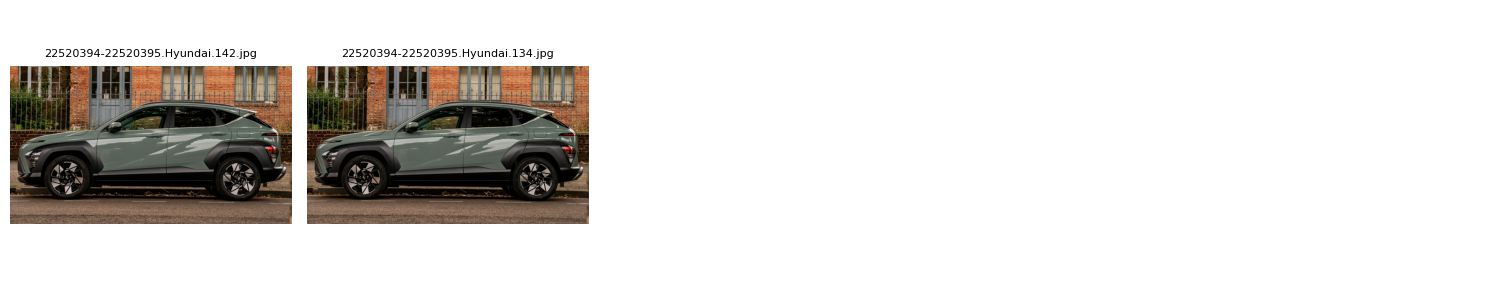


Cluster 1 (Directory: Hyundai):
/kaggle/input/car-cs114/dataset/Hyundai/22520459-22520507-22520862.Hyundai.96.jpg
/kaggle/input/car-cs114/dataset/Hyundai/22521465-22520811-22520683.Hyundai.4.jpg

Cluster 1:


In [ ]:
# Trích xuất danh sách thư mục duy nhất từ cột "ImageFullPath"
unique_directories = car_dataset["ImageFullPath"].apply(lambda x: x.split("/")[0]).unique()

# Lưu kết quả toàn cục vào một danh sách
all_results = []

# Lặp qua từng thư mục để tìm ảnh trùng
for directory in unique_directories:
    print(f"\nProcessing directory: {directory}")

    # Lọc các ảnh thuộc thư mục hiện tại
    folder_data = car_dataset[car_dataset["ImageFullPath"].str.startswith(directory)]
    image_paths = folder_data["FullImagePath"].tolist()

    # Rút trích đặc trưng
    features = []
    valid_paths = []  # Lưu trữ đường dẫn ảnh hợp lệ
    for path in image_paths:
        feature = extract_features(path, model)
        if feature is not None:
            features.append(feature)
            valid_paths.append(path)

    # Chuyển danh sách đặc trưng thành numpy array
    features = np.array(features)

    # Áp dụng DBSCAN để tìm ảnh trùng
    dbscan = DBSCAN(eps=5, min_samples=2, metric='euclidean')  # eps có thể cần điều chỉnh
    clusters = dbscan.fit_predict(features)

    # Lưu kết quả vào DataFrame
    cluster_df = pd.DataFrame({
        "ImagePath": valid_paths,
        "ClusterID": clusters
    })
    
    # Lọc các cluster có nhiều hơn 1 ảnh
    duplicate_clusters = cluster_df[cluster_df["ClusterID"] != -1].groupby("ClusterID")
    for cluster_id, group in duplicate_clusters:
        cluster_images = group["ImagePath"].tolist()
        print(f"\nCluster {cluster_id} (Directory: {directory}):")
        print("\n".join(cluster_images))
        display_cluster_images(cluster_id, cluster_images)
    
        # Ghi kết quả vào danh sách
        for img_path in cluster_images:
            # Lấy tên file ảnh từ đường dẫn đầy đủ
            original_path = car_dataset[car_dataset["FullImagePath"] == img_path]["ImageFullPath"].values[0]
            all_results.append({
                "ImageFullPath": original_path,  # Chỉ lưu đường dẫn gốc
                "ClusterID": cluster_id
            })

In [ ]:
# Ghi toàn bộ kết quả vào file CSV
output_csv = r"/kaggle/working/CheckDuplicate_Train_5.csv"
result_df = pd.DataFrame(all_results)
result_df.to_csv(output_csv, index=False)
print(f"\nDuplicate detection results saved to {output_csv}")